In [1]:
%run training_functions.ipynb

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-14 13:48:37.518326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744638517.534112  465559 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744638517.538856  465559 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744638517.553088  465559 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
['train', 'validation', 'test']
['train', 'validation', 'test']
In, Out, get_ipython, exit, quit, open, accelerate, datasets, evaluate, math, np, peft, pickle, pytest, ipytest, pd, transformers, torch, time, threading, load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names, LoftQConfig, LoraConfig, get_peft_model, AutoModelForCausalLM, AutoTokenizer, pipeline, TrainingArguments, Trainer, SFTTrainer, SFTConfig, @py_builtins, @pytest_ar, model_from_pkl, ds_builder1, ds_builder2, ds_builder3, ds_gs, ds_gst1_train, ds_gst1_test, ds_gst2_train, ds_gst2_test, search_with_strings, map_data, print_trainable_parameters, metric, heartbeat, initialize_heartbeat, end_heartbeat, comp_metrics_output, compute_metrics, make_trainer, get_dataframe, get_training_output, 

## Imported Functions
1. model_from_pkl(model): extracts ML model from pkl file
2. map_data(data, model, tokenizer): performs preprocessing/tokenization on data
3. make_trainer(m_model, train_data, test_data, config, args): creates training object with model, training arguments, train/test data, a configuration, and evaluation function
4. compute_metrics(eval_pred): used in the trainer, calculates prediction accuracy/validation loss
5. get_training_output(trainer, keys: list): extracts data from training logs
6. get_dataframe(training_output: list, strategy): used in get_training_output, puts training data into dataframe/graph form

In [2]:
print(ds_gst1_train[0]['record'])

NZ_LIXJ01000001.1


In [3]:
print(ds_gst1_train[0]['text'][:1000])

CGACTCCGCACAGGCCCTAGGCGTGGTCCACGCATCGAGCGCGTGCGCCGTGGCATACACCCGGGCCACCCGTACGACCCTTCCGGCCGCCCCGTGTGCGCCCTCGTCGCCGAGTCCGCTCCGGCGCGCGCGGGCGCACTGCTGTTCCGCGCGGTGTCATGCGCTCCTCCCGTCCCGACATGCGCCTTTTTGCAGGGGAGAGGGAGGGGTAGGGTCGCGCGTACGCCTAGCACGGGGGAACGGTCTTGGGGGACGCAGTGGACGTACGGGTGGCGGCGATCGCCAGTCTCACACCGCTCGAAGAACTCGACAGCGATCCGTTCCTCGTGGACACCCGCAGCCAGCACGACATGTGCGCACGCTGGGCCGCGGACAAGGGGTACGTCGTCACCCGCCAGCTCCGCTTCTACGGGCTGCGCCCCGATCACCACGCCCTGTGGAGCGATGTCGAGAGCGGCGACGTCGAGGTGTTCGTCGCCGCCAACGACCGGGTGCTGGAACGGGCCCTCACGTCGGTCGCGGAGTTCGCCGCGGAGTGCGCGCGGCGCGGCGTGCGTCTGGAGATCGCCGGGCTGGACGAGCCGCCGTACAACGCCGGCACGAAGGCGAGCGTGCATCGCAGGCTCTCCATGCCCACCGCCGGTTACGACGGCCGCTGACGCACTCCGCCTCCACTGCCGGCTCGCGGCCCCTGCCCTCGTCCCGGCCCCGTCCCTTCCGCGGCTTGCCGTCGGGCTGTGACAGGCTGGGGGACAGGGTCCGCAGCGGCGGGGCCCGGACGTGAGGTGGTTGAGGCGTGGGTGACGGGCGATGGCGAACGGTCGGCAACGCCCTGATGCGAGTGGCCGTGGTGTGGGCGGTCTCCACGCTCACGATGCTGGTGCTCGCCGGGGTGCTGCCGGAGTTCCGGCTCCAGTCGGACGACGGCGACAGCATCACCAAGACCGCGTTCACCGCGGCCTGGGGCGCCGGAGCGTTCGGCCTGCTCTCCGCACTCGTC

In [4]:
mistral, mistral_tokenizer=model_from_pkl("Mistral-7B-Instruct-v0.1")

In [5]:
m_tokenized_genome_samples=map_data(ds_gs, mistral, mistral_tokenizer)

In [6]:
m_tokenized_stage1_train=map_data(ds_gst1_train, mistral, mistral_tokenizer)
m_tokenized_stage1_test=map_data(ds_gst1_test, mistral, mistral_tokenizer)

In [7]:
m_tokenized_stage2_train=map_data(ds_gst2_train, mistral, mistral_tokenizer)
m_tokenized_stage2_test=map_data(ds_gst2_test, mistral, mistral_tokenizer)

In [8]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [9]:
mis_lora_model=get_peft_model(mistral, config)
print_trainable_parameters(mis_lora_model)

trainable params: 3407872 || all params: 7245139968 || trainable%: 0.05


In [10]:
m_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps", 
                                    logging_steps=5, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

# Using the SFTConfig default values provides us with...
# num_train_epochs = 3.0
# eval_strategy: typing.Union[transformers.trainer_utils.IntervalStrategy, str] = 'no'
# per_device_train_batch_size = 8
# learning_rate = 2e-5
# gradient_checkpointing=False

In [11]:
m_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
5,0.652900,2.578309,0.027344
10,0.645300,2.539101,0.026270
15,0.639100,2.510353,0.027148
20,0.628500,2.492171,0.027813
25,0.630600,2.480392,0.028730
30,0.624800,2.472588,0.028457
35,0.624100,2.467368,0.028438
40,0.618900,2.464368,0.028730
45,0.623900,2.462695,0.029785


The function is running
The function is running
The time taken was 88.53265182301402  seconds


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The time taken was 84.56001928495243  seconds


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The time taken was 83.80768366111442  seconds


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The time taken was 85.23241487331688  seconds


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The time taken was 83.92021991685033  seconds


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The time taken was 84.19826652901247  seconds


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The time taken was 83.38005809113383  seconds


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The time taken was 84.91862646304071  seconds


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The time taken was 83.73818627465516  seconds


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=48, training_loss=0.6314775149027506, metrics={'train_runtime': 909.1865, 'train_samples_per_second': 1.65, 'train_steps_per_second': 0.053, 'total_flos': 6.5563250393088e+16, 'train_loss': 0.6314775149027506})

,loss,eval_loss,eval_accuracy
steps,,,
5,0.6529,2.578309,0.027344
10,0.6453,2.539101,0.026270
15,0.6391,2.510353,0.027148
20,0.6285,2.492171,0.027813
25,0.6306,2.480392,0.028730
30,0.6248,2.472588,0.028457
35,0.6241,2.467368,0.028438
40,0.6189,2.464368,0.028730
45,0.6239,2.462695,0.029785


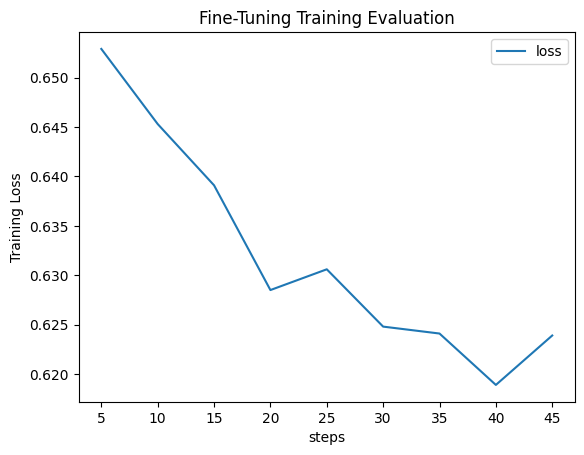

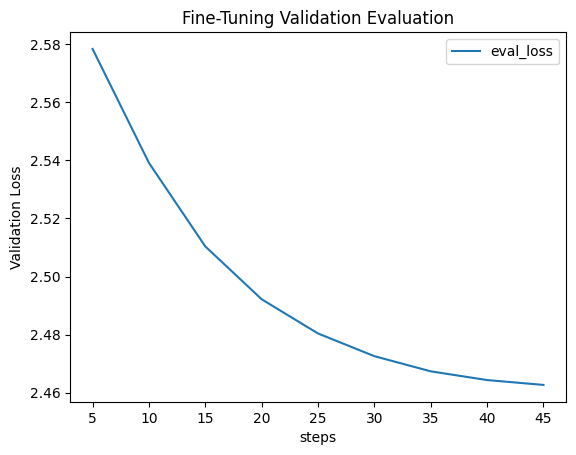

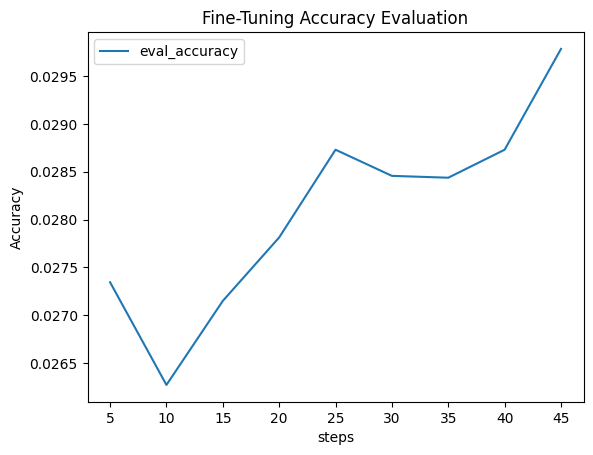

In [12]:
output=get_training_output(m_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [13]:
m2_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps", 
                                    logging_steps=2, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

In [14]:
m2_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.614400,2.441863,0.002578
2,0.612300,2.433959,0.007617
3,0.616800,2.431395,0.008867


The function is running
The function is running
The time taken was 86.622424909845  seconds


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The time taken was 86.88233246700838  seconds


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The time taken was 87.28449460910633  seconds


TrainOutput(global_step=48, training_loss=0.6158555323878924, metrics={'train_runtime': 363.5911, 'train_samples_per_second': 4.126, 'train_steps_per_second': 0.132, 'total_flos': 6.5563250393088e+16, 'train_loss': 0.6158555323878924})

,loss,eval_loss,eval_accuracy
epoch,,,
1.0,0.6144,2.441863,0.002578
2.0,0.6123,2.433959,0.007617
3.0,0.6168,2.431395,0.008867


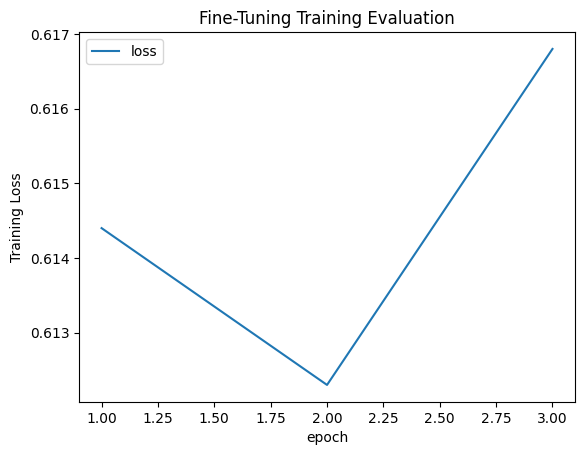

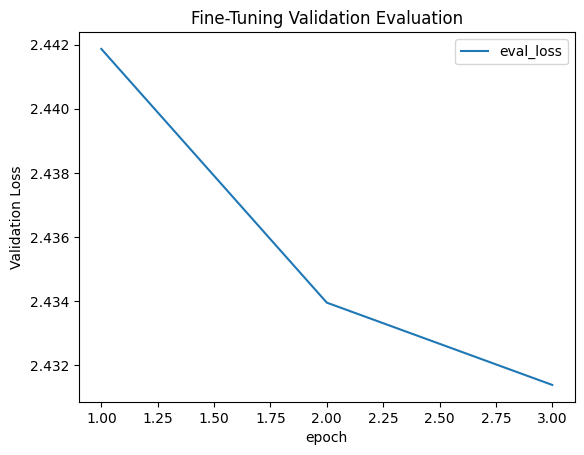

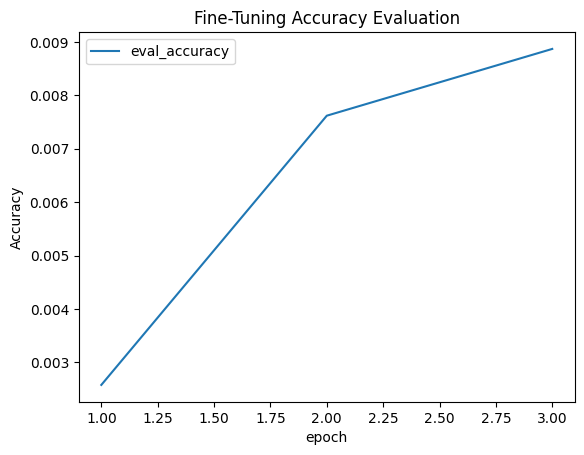

In [15]:
output=get_training_output(m2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [16]:
m_trainer.model.save_pretrained('./fine_tuned/mis/')
m2_trainer.model.save_pretrained('./fine_tuned/mis2/')

In [17]:
m_trainer.processing_class.save_pretrained('./fine_tuned/mis_token/')

('./fine_tuned/mis_token/tokenizer_config.json',
 './fine_tuned/mis_token/special_tokens_map.json',
 './fine_tuned/mis_token/tokenizer.model',
 './fine_tuned/mis_token/added_tokens.json',
 './fine_tuned/mis_token/tokenizer.json')

In [18]:
m2_trainer.processing_class.save_pretrained('./fine_tuned/mis2_token/')

('./fine_tuned/mis2_token/tokenizer_config.json',
 './fine_tuned/mis2_token/special_tokens_map.json',
 './fine_tuned/mis2_token/tokenizer.model',
 './fine_tuned/mis2_token/added_tokens.json',
 './fine_tuned/mis2_token/tokenizer.json')